In [0]:
#download pydrive
%pip install pydrive

# Drive authentification


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:

your_module = drive.CreateFile({'id':'[google_drive_file_id]'})


In [0]:
#To mount Google drive

from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#Change directory()

%cd "gdrive/My Drive/CAD/Dermoscopy/Pipeline"

/content/gdrive/My Drive/CAD/Dermoscopy/Pipeline


In [0]:
import tensorflow as tf
# Avoid Pre-Allocation + Dynamically Grow GPU RAM by TensorFlow
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


# Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, GlobalAveragePooling2D, Dense
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras import layers
from keras import Input

#changed to include pretrained network
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.callbacks import CSVLogger
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2

from random import shuffle
from keras.layers import Input, Conv2D, concatenate, UpSampling2D, BatchNormalization, Activation, Cropping2D, ZeroPadding2D
from keras.utils import plot_model 
from keras.preprocessing.image import ImageDataGenerator
import os


Using TensorFlow backend.



# Generators

In [0]:
x_wid, y_wid = (299, 299)
batch_size = 15
n_channels = 3

Here we use the combination of original training and validation images as input where we split it in 15% for validating and other 85% for training.

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Provide the same seed and keyword arguments to the fit and flow methods
seed1 = 1

# we create two instances with the same arguments
data_gen_args_im = dict(rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.9,1.1),
        fill_mode='nearest',
        validation_split = 0.15
        )
image_datagen = ImageDataGenerator(**data_gen_args_im)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

train_generator = image_datagen.flow_from_directory(
    'train_val',
    target_size=(x_wid, y_wid),
    batch_size=batch_size,
    color_mode='rgb',
    seed=seed,
    subset='training',
    class_mode='categorical'
    )

#train_generator = to_categorical(train_generator)

validation_generator = image_datagen.flow_from_directory(
    'train_val', 
    target_size=(x_wid, y_wid),
    batch_size=batch_size,
    color_mode='rgb',
    seed=seed,
    subset='validation',
    class_mode='categorical') 

#validation_generator = to_categorical(validation_generator)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


Found 5100 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


In this step, we visualize some of the images of training generator.

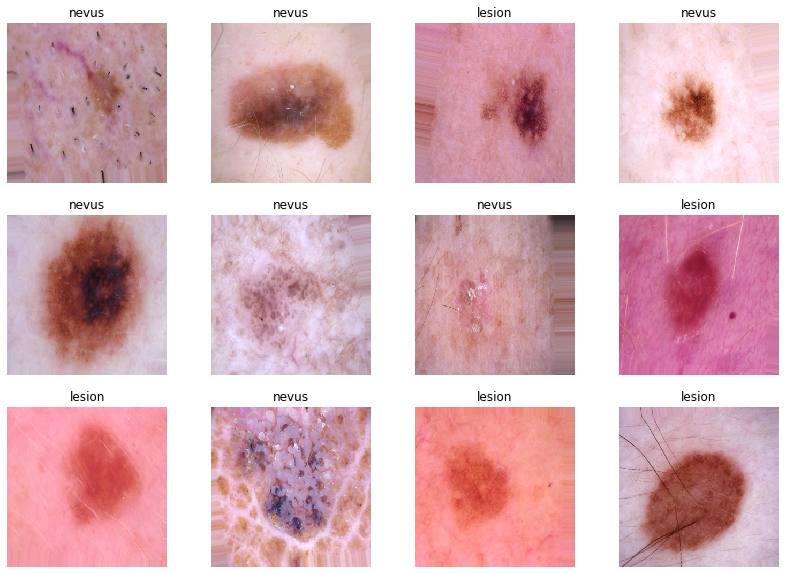

In [0]:
import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
def class_plot(data , n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (img,lbl) = data[a]
        #print(len(lbl))
        for label,image in zip(lbl[:,0],img):
          if label == 1.:
            l ='nevus'
          elif label ==0.:
            l ='lesion'
          image=np.array(image)     
          im = ax.imshow(image)
          ax.set_title(l)
          ax.axis('off')
        pass
        
    plt.show()
class_plot(train_generator)

# Model

**InceptionResNetV2**


In [0]:
x_wid, y_wid = (229, 229)
batch_size = 15
n_channels = 3

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

model_name='InceptionResNetV2'
inp = Input((x_wid, y_wid, n_channels))
sz = (x_wid, y_wid, n_channels)
x = Input(sz)
inputs = x
print("inputs shape: ", inputs.get_shape)

# create the base pre-trained model
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None)


In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:

count=0
for i, layer in enumerate(base_model.layers):
   count +=1
   print(i, layer.name)

n_train_layers = count
print ("Total Number of layers :", count)
   

Here, we train only the bottom layers after first 350 layers even though we train all the batch normalization layers as well. 

We flatten the last layer output using GlobalMaxPooling2D  and we add a fully connected layer with 512 hidden units and Relu activation with a drop out of 0.2.

In [ ]:
n_train_layers = 350

for layer in base_model.layers[:n_train_layers]:
    layer.trainable = False
    if isinstance(layer, keras.layers.normalization.BatchNormalization):
        layer.trainable = True

for layer in base_model.layers[n_train_layers:]:
    layer.trainable = True

last_layer = base_model.get_layer('conv_7b_ac')
print('last layer output shape :', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = ()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='softmax')(x)

# Configure and compile the model

base_model = Model(base_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


# Model Summary

In [0]:
#base_model.summary()

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

filepath = model_name+'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
#early = EarlyStopping(monitor="val_loss",                       mode="min",                       patience=20)
csv_logger = CSVLogger('log'+model_name+'.csv', append=True, separator=';')
callbacks_list = [csv_logger,checkpoint]


**Model.fit_generator**

In [0]:

loss_history = base_model.fit_generator(train_generator,steps_per_epoch=20,validation_data=validation_generator, epochs = 50, callbacks = callbacks_list )
session.close()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
20/20 [==============================] - 414s 21s/step - loss: 1.4208 - acc: 0.5500 - val_loss: 0.7552 - val_acc: 0.6689
Epoch 2/50
20/20 [==============================] - 80s 4s/step - loss: 0.7896 - acc: 0.6833 - val_loss: 0.6167 - val_acc: 0.7578
Epoch 3/50
20/20 [==============================] - 114s 6s/step - loss: 0.6954 - acc: 0.7433 - val_loss: 0.7028 - val_acc: 0.7211
Epoch 4/50
20/20 [==============================] - 125s 6s/step - loss: 0.6123 - acc: 0.7367 - val_loss: 0.4528 - val_acc: 0.8333
Epoch 5/50
20/20 [==============================] - 125s 6s/step - loss: 0.6127 - acc: 0.8067 - val_loss: 0.7250 - val_acc: 0.7567
Epoch 6/50
20/20 [==============================] - 111s 6s/step - loss: 0.6939 - acc: 0.7167 - val_loss: 0.4916 - val_acc: 0.8000
Epoch 7/50
20/20 [==============================] - 147s 7s/step - loss: 0.5035 - acc: 0.7733 - val_loss: 0.4808 - val

# Learning Curves


In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

###History of Loss and Accuracy 

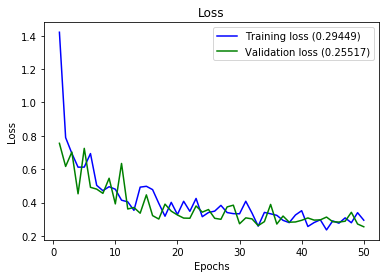

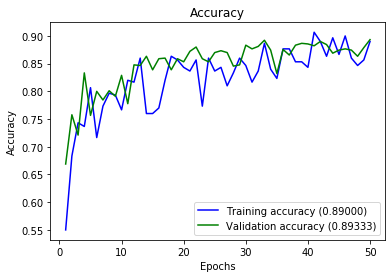

In [0]:
plot_history(loss_history)

# Prediction

In [ ]:
import pandas as pd
import os
from keras.preprocessing.image import load_img
prediction_filename=model_name+'test_pred'
test_dir='test'
threshold=0.5
test_sampels=os.listdir(test_dir)
ID=[]
test_predictions=[]
prediction_filename = "InceptionResNetV2"

for i in test_sampels:
  image = load_img(os.path.join(test_dir,i), target_size=(299, 299))
  print(i)
  # convert the image to an array
  img = img_to_array(image)
  print(img.shape)
  # expand dimensions so that it represents a single 'sample'

  image_norm=img/255
  image_norm = np.expand_dims(image_norm, axis=0)
  pred = base_model.predict(image_norm)
  print(pred)
  pred = np.argmax(pred, axis = 1)

  ID.append(str(i))
  test_predictions.append(pred)

TP=pd.DataFrame(list(zip(ID, test_predictions)),
columns=['id','prediction'])
TP.to_csv(prediction_filename+".csv", encoding='utf-8', index=False)

**Confidence**

In [ ]:
import pandas as pd
import os
from keras.preprocessing.image import load_img
prediction_filename=model_name+'test_pred'
test_dir='test'
threshold=0.5
test_sampels=os.listdir(test_dir)
ID=[]
test_predictions=[]
prediction_filename = "InceptionResNetV2_Confidence"

for i in test_sampels:
  image = load_img(os.path.join(test_dir,i), target_size=(299, 299))
  print(i)
  # convert the image to an array
  img = img_to_array(image)
  print(img.shape)
  # expand dimensions so that it represents a single 'sample'

  image_norm=img/255
  image_norm = np.expand_dims(image_norm, axis=0)
  pred = base_model.predict(image_norm)
  print(pred)
  #pred = np.argmax(pred, axis = 1)


  
  ID.append(str(i))
  test_predictions.append(pred)

TP=pd.DataFrame(list(zip(ID, test_predictions)),
columns=['id','prediction'])
TP.to_csv(prediction_filename+".csv", encoding='utf-8', index=False)